"Causal Modeling of time of day, ac, window, and thermometer"
module Thermometer

In [1]:
using Omega, Plots

┌ Info: Recompiling stale cache file /home/zenna/.julia/compiled/v1.0/Omega/a1aeQ.ji for Omega [f05e9b56-6544-11e8-2dc8-1fe18f3ca5da]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/zenna/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


Create a model. Firstm a uniform distribution over the time of day

In [2]:
timeofday = uniform([:morning, :afternoon, :evening])

3:UniformChoice(Symbol[:morning, :afternoon, :evening])::Symbol

The window is either open or not (with equal probability)

In [3]:
is_window_open = bernoulli(0.5, Bool)

4:Bernoulli(0.5)::Bool

Turn off the a.c. when the window is closed!

In [4]:
const is_ac_on = ciid(rng -> is_window_open(rng[@id]) ? false : bernoulli(rng[@id], 0.5, Bool))

7:getfield(Main, Symbol("##7#8"))()()::Bool

The outside temperature is normally distributed with a mean depending on the time of day

In [5]:
function outside_temp_(rng)
  tod = timeofday(rng[@id])
  if tod == :morning
    normal(rng[@id], 20.0, 2.0)
  elseif tod == :afternoon
    normal(rng[@id], 32.0, 2.0)
  else
    normal(rng[@id], 10.0, 2.0)
  end
end

const outside_temp = ciid(outside_temp_)

12:outside_temp_()::Float64

The inside temperature is normally distributed with a mean depending on whether the ac is on

In [6]:
function inside_temp_(rng)
  if is_ac_on(rng[@id])
    normal(rng[@id], 20.0, 2.0)
  else
    normal(rng[@id], 25.0, 2.0)
  end
end

const inside_temp = ciid(inside_temp_)

16:inside_temp_()::Float64

The room is a perfect insulator: when the window is closed its only the inside temperature that matters
Otherwise, its the mean of the outside and inside temperatures

In [7]:
function thermometer_(rng)
  if is_window_open(rng)
    (outside_temp(rng[@id]) + inside_temp(rng[@id])) / 2.0
  else
    inside_temp(rng[@id])
  end
end

const thermometer = ciid(thermometer_)

function plothist(samples; bins = 100, kwargs...)
  Plots.histogram(samples;
                  bins = bins,
                  normalize = true,
                  yticks = [],
                  xtickfont= Plots.font("Helvetica", 20),
                  label = "",
                  kwargs...)
end

function plotbar(scenarios)
  counts(xs::Vector{T}) where T = (d = Dict{T, Int}(); foreach(x -> d[x] = get!(d, x, 0) + 1, xs); d)
  seccounts = counts(scenarios)
  Plots.bar(string.(collect((keys(seccounts)))), collect(values(seccounts)),
            normalize=true)
end

plotbar (generic function with 1 method)

Given the model, we can now define queries #

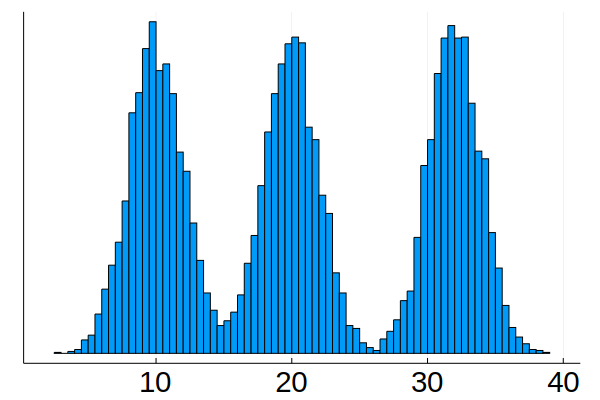

In [8]:
const allvars = (timeofday, is_window_open, is_ac_on, outside_temp, inside_temp, thermometer)

priorsamples = rand(outside_temp, 10000, alg = RejectionSample)
plothist(priorsamples)

Conditional Inference: the thermometer reads hot. What does this tell you about outside temp?

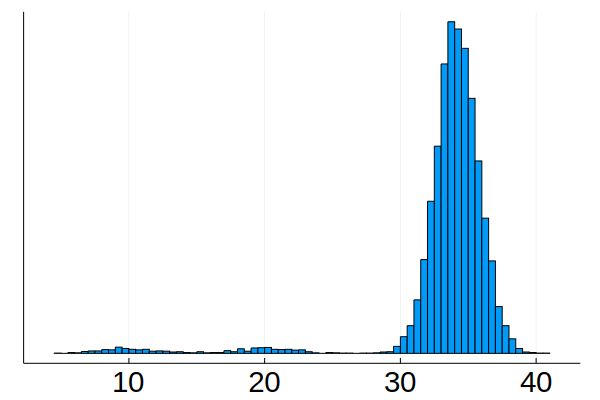

In [9]:
priorsamplescond = rand(outside_temp, thermometer > 30.0, 10000, alg = RejectionSample)
plothist(priorsamplescond)

You intervene on thermometer to be hot,  What does this tell you about outside temp? (answer: nothing!)

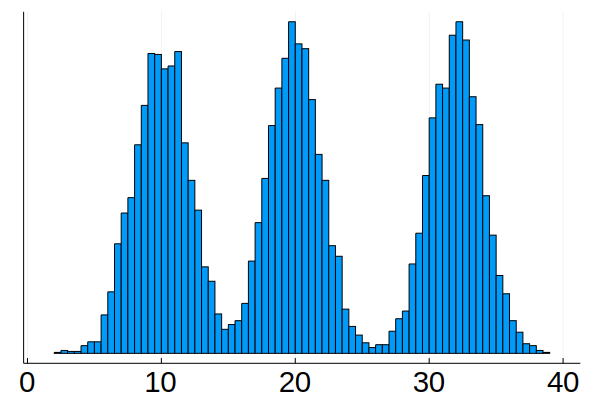

In [10]:
outside_temp_do = replace(outside_temp, thermometer => 35.0)
priorsamplesdo = rand(outside_temp_do, 10000, alg = RejectionSample)
plothist(priorsamplesdo)

Prior thermometer reading

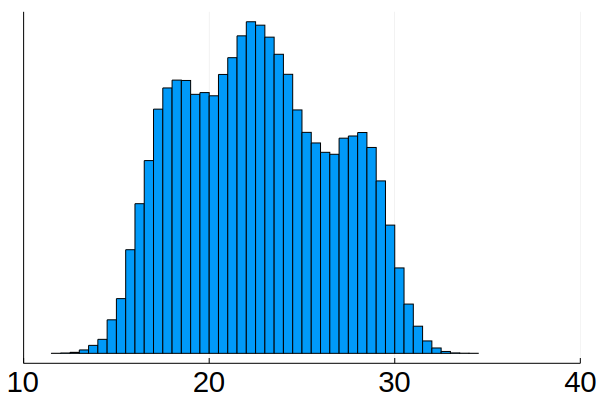

In [11]:
thermopriorsamples = rand(thermometer, 100000, alg = RejectionSample)
plothist(thermopriorsamples, bins = 100, xlim = (10, 40))

If I were to close the window and turn on the AC would that make it hotter or colder

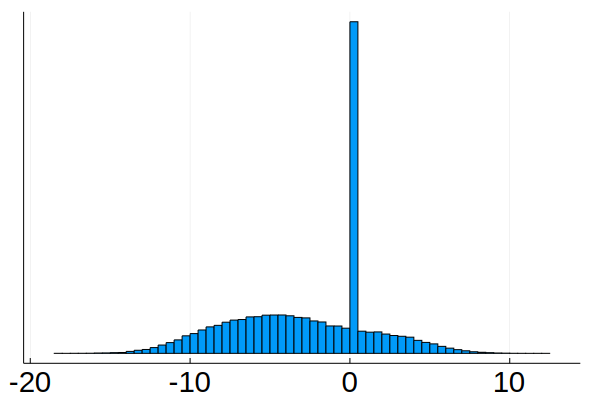

In [12]:
thermometernew = replace(thermometer, is_ac_on => true, is_window_open => false)
diffs = rand(thermometernew - thermometer, 100000, alg = RejectionSample)
plothist(diffs, bins = 100)

In what scenarios would it still be hotter after turning on the AC and closing the window?

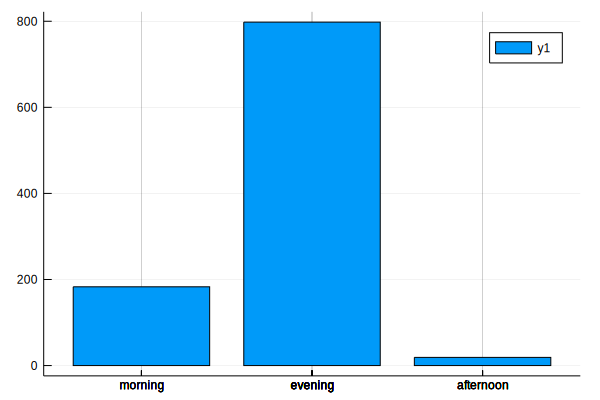

In [13]:
scenarios = rand(timeofday, thermometernew - thermometer > 0.0, 1000, alg = RejectionSample)
plotbar(scenarios)

What if we opened the window and turned the AC on (logical inconsistency w.r.t to original model)

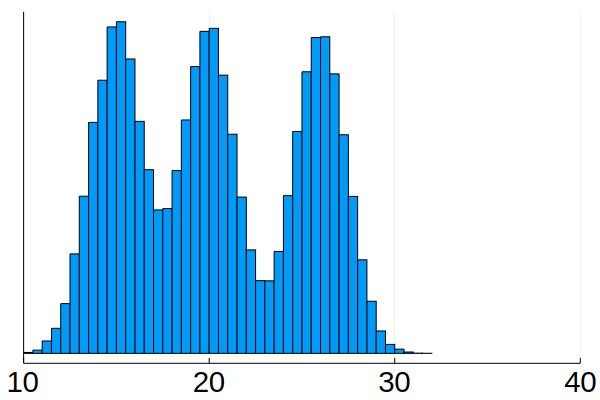

In [14]:
thermometer_imposs = replace(thermometer, is_ac_on => true, is_window_open => true)
samples_imposs = rand(thermometer_imposs, 100000, alg = RejectionSample)
plothist(samples_imposs, bins = 100, xlim = (10, 40))

savefig("dothermoimposs.svg")

In [15]:
diffsamples_imposs = rand(thermometer_imposs - thermometer, 10000, alg = RejectionSample)
plothist(diffsamples_imposs, bins = 100, xlim = :auto)
mean(diffsamples_imposs)

-2.315564251132162

end#-
*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*